### Author
 - Gioele Modica

In [ ]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import os
import matplotlib.animation as animation
from skimage.transform import resize
from skimage.filters import gaussian
from skimage import exposure
from skimage.filters import threshold_otsu
from skimage.morphology import ball, opening, closing, remove_small_objects, remove_small_holes
import SimpleITK as sitk
from scipy.ndimage import uniform_filter
import itertools
import tqdm

# Functions

In [306]:
def load_dicom_series(directory):
    """Load a series of DICOM files from a directory and return as 3D numpy array"""
    files = [pydicom.dcmread(os.path.join(directory, f)) for f in sorted(os.listdir(directory))]
    slices = [f.pixel_array for f in files]
    return np.stack(slices, axis=0)

def load_single_dicom(filepath):
    """Load a single DICOM file"""
    ds = pydicom.dcmread(filepath)
    return ds.pixel_array

In [307]:
def extract_bounding_box(mask_volume):
    """Extract 3D bounding box coordinates from a binary mask volume"""
    labeled = label(mask_volume)
    props = regionprops(labeled)
    
    if len(props) == 0:
        return None
        
    bbox = props[0].bbox  # (min_z, min_y, min_x, max_z, max_y, max_x)
    return {
        'z_start': bbox[0],
        'z_end': bbox[3],
        'y_start': bbox[1],
        'y_end': bbox[4],
        'x_start': bbox[2],
        'x_end': bbox[5]
    }

In [308]:
def plot_slice_with_bbox(image_slice, mask_slice=None, bbox_coords=None, title=None):
    """Plot slice with mask and bounding box rectangle"""
    plt.figure(figsize=(10, 5))
    plt.imshow(image_slice, cmap='gray')
    
    if mask_slice is not None:
        mask_slice = np.ma.masked_where(mask_slice == 0, mask_slice)
        plt.imshow(mask_slice, cmap='autumn', alpha=0.3, label='Tumor Mask')
    
    if bbox_coords is not None:
        # Draw bounding box rectangle
        width = bbox_coords['x_end'] - bbox_coords['x_start']
        height = bbox_coords['y_end'] - bbox_coords['y_start']
        rect = plt.Rectangle((bbox_coords['x_start'], bbox_coords['y_start']),
                            width, height,
                            linewidth=2, edgecolor='lime', 
                            facecolor='none', label='Bounding Box')
        plt.gca().add_patch(rect)
    
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

In [309]:
def crop_to_bbox(volume, bbox):
    """Crop a 3D volume to bounding box dimensions"""
    return volume[bbox['z_start']:bbox['z_end'],
                bbox['y_start']:bbox['y_end'],
                bbox['x_start']:bbox['x_end']]

In [310]:
def postprocess_segmentation(segmented):
    """Post-process the segmentation result to remove small objects and holes."""
    # closing + opening
    struct = ball(2) 
    seg = closing(segmented, struct)
    seg = opening(seg, struct)

    
    seg = remove_small_objects(seg, min_size=1000)
    seg = remove_small_holes(seg, area_threshold=1000)

    # keep only the largest connected component
    labels = label(seg)
    props = regionprops(labels)
    if props:
        largest = max(props, key=lambda p: p.area).label
        seg = (labels == largest)

    return seg


In [311]:
def compare_masks(ground_truth, predicted):
    """Compare two binary masks and calculate Dice and Jaccard coefficients"""
    # Check if the shapes of the masks are the same
    if ground_truth.shape != predicted.shape:
        # Find the minimum dimensions
        min_z = min(ground_truth.shape[0], predicted.shape[0])
        min_y = min(ground_truth.shape[1], predicted.shape[1])
        min_x = min(ground_truth.shape[2], predicted.shape[2])
        
        # Crop the masks to the minimum dimensions
        gt_cropped = ground_truth[:min_z, :min_y, :min_x]
        pred_cropped = predicted[:min_z, :min_y, :min_x]
    else:
        gt_cropped = ground_truth
        pred_cropped = predicted
    
    # Calculate Dice and Jaccard coefficients
    intersection = np.logical_and(gt_cropped, pred_cropped)
    union = np.logical_or(gt_cropped, pred_cropped)
    
    dice = 2 * intersection.sum() / (gt_cropped.sum() + pred_cropped.sum())
    jaccard = intersection.sum() / union.sum()
    
    return {
        'dice': dice,
        'jaccard': jaccard,
        'voxel_accuracy': (gt_cropped == pred_cropped).mean()
    }

In [312]:
def region_growing_segmentation(image_volume, seed_point,
                                threshold=20, bbox=None,
                                gradient_thresh=10,
                                var_thresh=0.01,  
                                max_radius=None, max_voxels=50000):
    """Perform region growing segmentation on a 3D image volume."""

    gradient_magnitude = np.sqrt(sum(g**2 for g in np.gradient(image_volume)))
    # Calculate local variance
    mean1 = uniform_filter(image_volume, size=3)
    mean2 = uniform_filter(image_volume**2, size=3)
    local_var = mean2 - mean1**2

    if isinstance(seed_point, dict):
        seed_point = (seed_point['z'], seed_point['y'], seed_point['x'])
    seed_arr = np.array(seed_point, int)

    segmented = np.zeros_like(image_volume, bool)
    to_visit = [seed_point]

    while to_visit:
        z,y,x = to_visit.pop(0)
        if segmented[z,y,x]:
            continue

        if bbox:
            z0,z1 = bbox['z_start'], bbox['z_end']
            y0,y1 = bbox['y_start'], bbox['y_end']
            x0,x1 = bbox['x_start'], bbox['x_end']
            if not (z0 <= z <= z1 and y0 <= y <= y1 and x0 <= x <= x1):
                continue
            
        # Check if the voxel is within the image volume
        th = threshold[z] if isinstance(threshold, dict) else threshold
        if image_volume[z,y,x] < th:
            continue

        # Check if the voxel is within the local variance threshold
        if local_var[z,y,x] > var_thresh:
            continue

        # spatial stop
        if max_radius is not None and np.linalg.norm(np.array([z, y, x]) - seed_arr) > max_radius:
            continue
        if gradient_magnitude[z,y,x] > gradient_thresh:
            continue

        # voxel count stop
        if segmented.sum() >= max_voxels:
            return segmented

        segmented[z, y, x] = True

        # enqueue integer neighbors
        for dz, dy, dx in [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]:
            nz, ny, nx = z + dz, y + dy, x + dx
            if 0 <= nz < image_volume.shape[0] and 0 <= ny < image_volume.shape[1] and 0 <= nx < image_volume.shape[2]:
                to_visit.append((int(nz), int(ny), int(nx)))

    return segmented


In [ ]:
def grid_search_region_growing(subvol, seed_subvol, tumor_mask_subvol,
                               th_per_slice,
                               param_grid,
                               max_voxels=50000):
    """
    Perform grid search over region growing parameters and return best result.
    """
    best_score = -1.0
    best_params = None
    best_segmented = None
    best_segmented_clean = None

    # Iterate over all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    for combo in tqdm.tqdm(itertools.product(*values), desc="Grid Search"):
        params = dict(zip(keys, combo))
        # Run segmentation
        seg = region_growing_segmentation(
            subvol,
            seed_subvol,
            threshold=th_per_slice,
            gradient_thresh=params['gradient_thresh'],
            var_thresh=params['var_thresh'],
            max_radius=params['max_radius'],
            max_voxels=max_voxels
        )
        seg_clean = postprocess_segmentation(seg)
        # Compute metric (here usiamo Dice)
        metrics = compare_masks(tumor_mask_subvol, seg_clean)
        score = metrics['dice']
        
        if score > best_score:
            best_score = score
            best_params = params
            best_segmented = seg
            best_segmented_clean = seg_clean

    return best_params, best_score, best_segmented, best_segmented_clean

In [314]:
def plot_slice_with_masks(image_slice, gt_mask=None, pred_mask=None, title=None):
    """Plot a single slice with optional ground truth and predicted masks overlay"""
    plt.figure(figsize=(10, 5))
    
    plt.imshow(image_slice, cmap='gray')
    
    if gt_mask is not None:
        gt_mask = np.ma.masked_where(gt_mask == 0, gt_mask)
        plt.imshow(gt_mask, cmap='autumn', alpha=0.3, label='Ground Truth')
    
    if pred_mask is not None:
        pred_mask = np.ma.masked_where(pred_mask == 0, pred_mask)
        plt.imshow(pred_mask, cmap='winter', alpha=0.3, label='Predicted')
    
    if title:
        plt.title(title)
    
    plt.legend()
    plt.show()

In [315]:
def plot_multiplanar_slices(volume, tumor_mask, segmentation_mask, cross_coords=None, bbox=None):
    """
    Plot axial, sagittal and coronal slices with overlays:
     - bounding box,
     - ground truth tumor_mask (autumn),
     - predicted segmentation_mask (winter).
    """
    # Get center coords
    z, y, x = cross_coords['z'], cross_coords['y'], cross_coords['x']

    # Extract views
    axial_img,    axial_gt,    axial_pred    = volume[z],      tumor_mask[z],      segmentation_mask[z]
    sagittal_img, sagittal_gt, sagittal_pred = volume[:,:,x],   tumor_mask[:,:,x],   segmentation_mask[:,:,x]
    coronal_img,  coronal_gt,  coronal_pred  = volume[:,y,:],  tumor_mask[:,y,:],  segmentation_mask[:,y,:]

    target_shape = axial_img.shape
    # compute scales for sagittal & coronal bbox resizing
    row_scale       = target_shape[0] / volume.shape[0]
    col_scale_sag   = target_shape[1] / volume.shape[1]
    col_scale_cor   = target_shape[1] / volume.shape[2]

    def resize_pair(img, msk):
        img_rs = resize(img, target_shape, preserve_range=True, anti_aliasing=True)
        msk_rs = resize(msk, target_shape, preserve_range=True, anti_aliasing=False) > 0.5
        return img_rs, msk_rs

    # resize sagittal & coronal pairs
    sagittal_img, sagittal_gt = resize_pair(sagittal_img, sagittal_gt)
    sagittal_pred = resize(sagittal_pred, target_shape,
                           preserve_range=True,
                           anti_aliasing=False) > 0.5

    coronal_img, coronal_gt = resize_pair(coronal_img, coronal_gt)
    coronal_pred = resize(coronal_pred, target_shape,
                          preserve_range=True,
                          anti_aliasing=False) > 0.5

    views = {
        'Axial':    (axial_img, axial_gt, axial_pred),
        'Sagittal': (sagittal_img, sagittal_gt, sagittal_pred),
        'Coronal':  (coronal_img, coronal_gt, coronal_pred)
    }

    fig, axes = plt.subplots(1, 3, figsize=(15,5), subplot_kw={'aspect':'equal'})
    for ax, (title, (img, gt, pred)) in zip(axes, views.items()):
        ax.imshow(img, cmap='gray')
        ax.imshow(np.ma.masked_where(gt==0, gt), cmap='autumn', alpha=0.3)
        ax.imshow(np.ma.masked_where(pred==0, pred), cmap='winter', alpha=0.3)

        # draw resized bounding box
        if bbox is not None:
            if title == 'Axial':
                x0, y0 = bbox['x_start'], bbox['y_start']
                w = bbox['x_end'] - bbox['x_start']
                h = bbox['y_end'] - bbox['y_start']
            elif title == 'Sagittal':
                x0 = bbox['y_start'] * col_scale_sag
                y0 = bbox['z_start'] * row_scale
                w  = (bbox['y_end'] - bbox['y_start']) * col_scale_sag
                h  = (bbox['z_end'] - bbox['z_start']) * row_scale
            else:  # Coronal
                x0 = bbox['x_start'] * col_scale_cor
                y0 = bbox['z_start'] * row_scale
                w  = (bbox['x_end'] - bbox['x_start']) * col_scale_cor
                h  = (bbox['z_end'] - bbox['z_start']) * row_scale
            rect = plt.Rectangle((x0, y0), w, h, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

        ax.set_title(title)
        ax.axis('off')

    fig.tight_layout()
    plt.show()

In [316]:
def exec():
    reference_volume = load_dicom_series('1493/30_EQP_Ax5.00mm')
    tumor_mask = load_single_dicom('1493/30_EQP_Ax5.00mm_ManualROI_Tumor.dcm')
    sitk_img = sitk.Cast(sitk.GetImageFromArray(reference_volume), sitk.sitkFloat32)
    mask_otsu = sitk.OtsuThreshold(sitk_img, 0, 1)
    sitk_corrected = sitk.N4BiasFieldCorrectionImageFilter().Execute(sitk_img, mask_otsu)
    reference_volume = sitk.GetArrayFromImage(sitk_corrected)
    reference_volume = (reference_volume - reference_volume.min()) / (reference_volume.max() - reference_volume.min())

    bbox = extract_bounding_box(tumor_mask)
    seed_point = {
        'z': (bbox['z_start'] + bbox['z_end']) // 2,
        'y': (bbox['y_start'] + bbox['y_end']) // 2,
        'x': (bbox['x_start'] + bbox['x_end']) // 2
    }

    subvol = crop_to_bbox(reference_volume, bbox)
    tumor_mask_subvol = crop_to_bbox(tumor_mask, bbox)
    seed_subvol = {
        'z': seed_point['z'] - bbox['z_start'],
        'y': seed_point['y'] - bbox['y_start'],
        'x': seed_point['x'] - bbox['x_start']
    }
    bbox_subvol = extract_bounding_box(tumor_mask_subvol)

    # Precompute threshold per slice
    th_per_slice = {z: threshold_otsu(subvol[z]) for z in range(subvol.shape[0])}
    # Preprocess
    subvol = gaussian(subvol, sigma=1, preserve_range=True)
    subvol = np.stack([exposure.equalize_hist(subvol[z]) for z in range(subvol.shape[0])], axis=0)

    # Definisci il grid di parametri da esplorare
    param_grid = {
        'gradient_thresh': [2, 3, 5, 8, 10, 15, 20, 25], 
        'var_thresh':      [0.005, 0.015, 0.01, 0.02, 0.03, 0.04, 0.025],  
        'max_radius':      [20, 25, 30, 35], 
    }

    # Lancia la grid search
    best_params, best_score, best_seg, best_seg_clean = grid_search_region_growing(
        subvol, seed_subvol, tumor_mask_subvol,
        th_per_slice, param_grid,
        max_voxels=50000
    )

    # Stampa e plot solo del migliore 😊
    print("\n=== Best parameters ===")
    for k, v in best_params.items():
        print(f"{k}: {v}")
    print(f"Best Dice score: {best_score:.4f}\n")

    print("Plotting best raw segmentation:")
    plot_multiplanar_slices(subvol, tumor_mask_subvol, best_seg,
                            cross_coords=seed_subvol, bbox=bbox_subvol)
    print("Plotting best cleaned segmentation:")
    plot_multiplanar_slices(subvol, tumor_mask_subvol, best_seg_clean,
                            cross_coords=seed_subvol, bbox=bbox_subvol)


# Execution

Params: {'gradient_thresh': 2, 'var_thresh': 0.005, 'max_radius': 20} -> Dice: 0.1692
Params: {'gradient_thresh': 2, 'var_thresh': 0.005, 'max_radius': 25} -> Dice: 0.2349
Params: {'gradient_thresh': 2, 'var_thresh': 0.005, 'max_radius': 30} -> Dice: 0.2578
Params: {'gradient_thresh': 2, 'var_thresh': 0.005, 'max_radius': 35} -> Dice: 0.2517
Params: {'gradient_thresh': 2, 'var_thresh': 0.015, 'max_radius': 20} -> Dice: 0.4701
Params: {'gradient_thresh': 2, 'var_thresh': 0.015, 'max_radius': 25} -> Dice: 0.5358
Params: {'gradient_thresh': 2, 'var_thresh': 0.015, 'max_radius': 30} -> Dice: 0.5451
Params: {'gradient_thresh': 2, 'var_thresh': 0.015, 'max_radius': 35} -> Dice: 0.5061
Params: {'gradient_thresh': 2, 'var_thresh': 0.01, 'max_radius': 20} -> Dice: 0.3889
Params: {'gradient_thresh': 2, 'var_thresh': 0.01, 'max_radius': 25} -> Dice: 0.4772
Params: {'gradient_thresh': 2, 'var_thresh': 0.01, 'max_radius': 30} -> Dice: 0.4766
Params: {'gradient_thresh': 2, 'var_thresh': 0.01, 'max_r

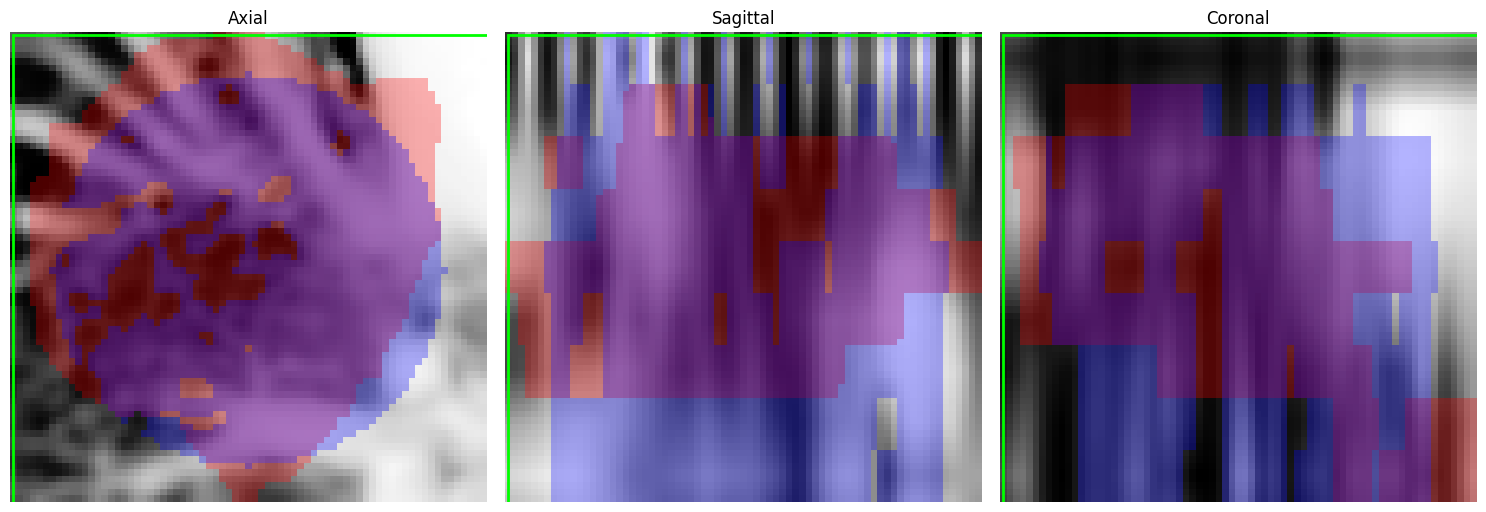

Plotting best cleaned segmentation:


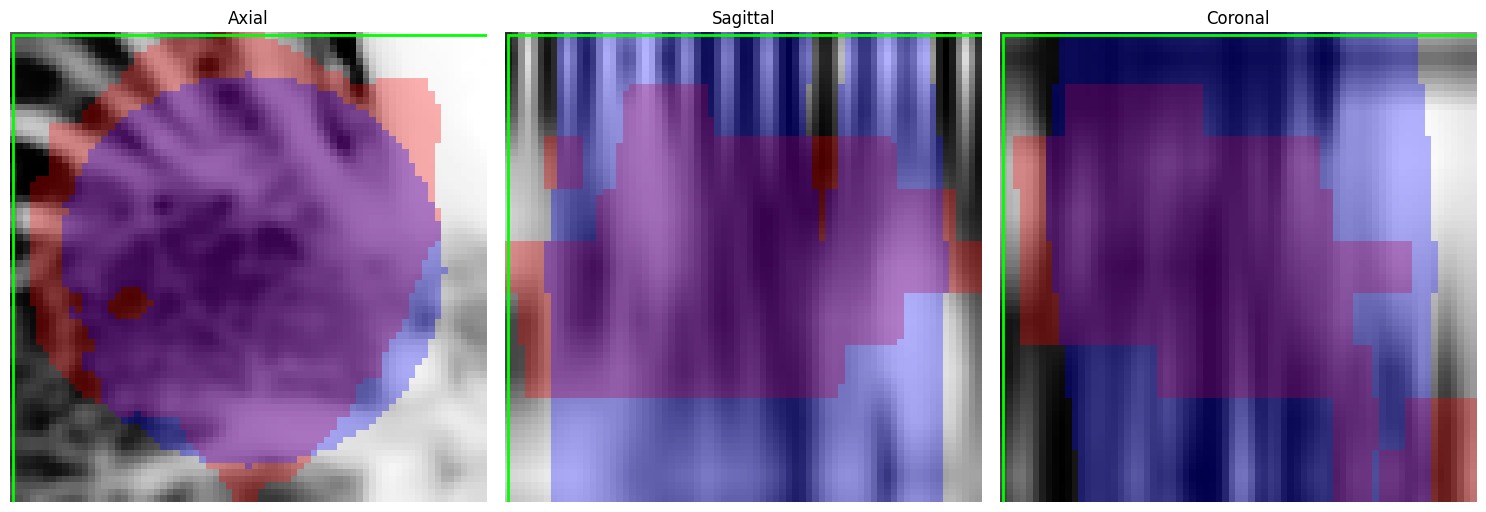

In [317]:
exec()